# DEMO: affine optical flow

Contributors: Thijs Willems

KU Leuven, LMSD

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

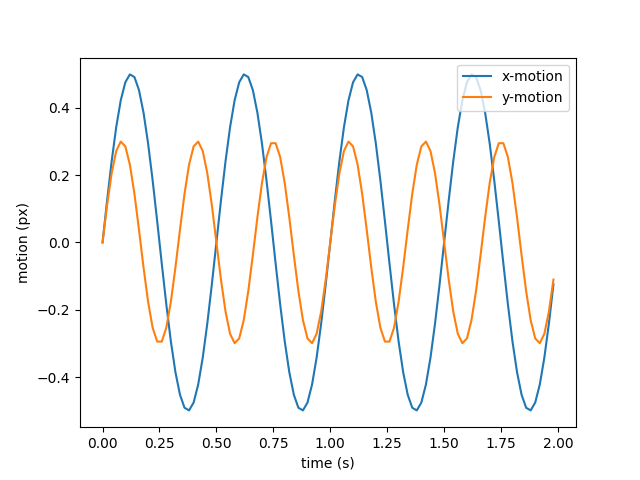

In [2]:
# Reference motion -> the tracked motion should be equal to this motion as this motion profile was used to generate the speckle frames
reference_motion_file = ".\\test_data\\virtual_video\\virtual_video_reference_motion.npz"
reference_motion = np.load(reference_motion_file)

t = reference_motion['t']
x_motion = reference_motion['motion_data'][0, :, 0]
y_motion = reference_motion['motion_data'][0, :, 1]

fig = plt.figure()
plt.plot(t,x_motion, label='x-motion')
plt.plot(t,y_motion, label='y-motion')
plt.xlabel('time (s)')
plt.ylabel('motion (px)')
plt.legend()
plt.show()

In [3]:
from image_data import imageStream
from detect_shitomasi import detect_shitomasi
from tracking import Tracker

test_data_frames = ".\\test_data\\virtual_video\\virtual_video_frames"

# Load data
stream = imageStream(name='ImageStream', data=test_data_frames, color_scheme='GRAY', bit_depth='UNCHANGED')

# ROI mask (the whole image, except the region too close to the image borders)
roi_mask = np.zeros_like(stream[0])
border_size = 25
roi_mask[border_size:roi_mask.shape[0]-border_size, border_size:roi_mask.shape[1]-border_size] = 255

# Detect points to track
# -> just to generate a set of initial points -> here you will use the AI tracker
# -> Output = matrix (#points, #frames, #2 (x and y coordinates))
points = detect_shitomasi(stream[0], shitomasi_parameters=dict(maxCorners=10, qualityLevel=0.01, minDistance=3, blockSize=9), mask=roi_mask,
               subpixel_refinement='off', subpixel_parameters=None,
               iteration_criteria=(cv.TERM_CRITERIA_MAX_ITER + cv.TERM_CRITERIA_EPS, 1000, 0.001),
               processor='cpu',
               verboseFlag=0)

# Motion tracking
# -> the actual tracking
# -> the most important thing here is that you will add an initial_guess_function based on the tracked AI positions
# -> in the tracker (cf tracking.py), this function is called on line 211
# -> in principle the function should take the frame number as input argument and return the guessed positions of the points in that frame as an array shape=(#point, 1, 2)
# -> of course you/we can change the scrips as you wish
tracker = Tracker(images=stream, feature_points=points, nr_frames=-1, motion_method='absolute', tracking_method='aof', 
                  aof_params=dict(win_size=(25, 25), 
                                  pyr_params=(0, 'OpenCV', 0), 
                                  iteration_criteria=(100, 0.01),
                                  condition_check=False,
                                  image_normalization='none',
                                  weighting = 'none', 
                                  occlusion_method = 'none',
                                  grad_method='cd', grad_sigma=0, verbosityFlag=0, 
                                  model_reduction='translation', motion_model='affine'),
                  initial_guess_function=None, backtracking=None, reject_param=None, grouping=None, fps=900
)
tracker.calc()
motion = tracker.tracks


Tracking (Method: aof): 100%|██████████| 100/100 [00:09<00:00, 10.91it/s]


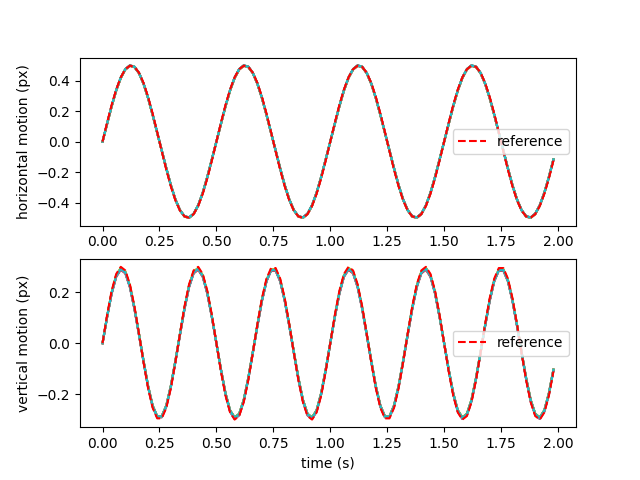

In [4]:
# Plot tracked data -> should be equal to the reference motion (red dashed line)
fig, [ax1, ax2] = plt.subplots(2,1)
ax1.plot(t, np.transpose(motion[:, :, 0]-motion[:, [0], 0]))
ax1.plot(t, x_motion, 'r--', label='reference')
ax1.set_ylabel('horizontal motion (px)')
ax1.legend()
ax2.plot(t, np.transpose(motion[:, :, 1]-motion[:, [0], 1]))
ax2.plot(t, y_motion, 'r--', label='reference')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('vertical motion (px)')
ax2.legend();